In [1]:
import time
import re
import pylab as pl
import numpy as np
import pylab as pl

from datetime import datetime, timedelta

import subprocess

import os
import pandas as pd

import concurrent.futures


from joblib import Parallel, delayed
import shutil


from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [2]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')   


ERROR: (gcloud.compute.instances.delete) Could not fetch resource:
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-25' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-26' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-27' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-28' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-29' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-30' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-31' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-32' was not found
 - The resource 'projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/inst

512

In [3]:

def str2datetime(s):
    parts = s.split('.')
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S")
    return dt.replace(microsecond=int(parts[1]))


def remove_outliers(x, outlierConstant = 1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    removedList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
        else:
            removedList.append(y)
    return (resultList, removedList)
def getThroughput(experiment):

    result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


    result = result.decode("utf-8") 

    lines = result.split('\n')

    commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
#     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

    Times = []
    lats = []

    for line in lines:
        m = commit_pat.match(line)
        if m:
            try:

                time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
                float((line.split(' ')[1]).split(':')[2])
                Times.append(time_item)        

                lats.append(float(m.group(2)))
            except:
                continue


    begin_time = None
    values = []
    interval = 1
    cnt = 0
    Times.sort()
    for timestamp in Times:
        if begin_time is None:
            begin_time = timestamp
            next_begin_time = timestamp +interval

        while timestamp >= next_begin_time:
            begin_time = next_begin_time
            next_begin_time += interval
            values.append(cnt)
            cnt = 0
        cnt += 1
    values.append(cnt)

#     lats, _ = remove_outliers(lats)
#     print(len(values))


    return np.arange(len(values))*interval,np.array(values)/interval, lats

In [4]:
# p = subprocess.Popen(['../../hotstuff-keygen', ' --num', '--n', str(4)],
#                      stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'))

In [5]:
# print([[t[4:] for t in l.decode('ascii').split()] for l in p.stdout])
# # [[t for t in l.decode('ascii').split()] for l in p.stdout.read()]

In [6]:
# os.system('echo 3108 | sudo -S sh job_mini.sh '+ 'test')


In [ ]:
# regions= ['us-west-1', 'ap-south-1']
# regions= ['ap-south-1', 'eu-central-1', 'us-west-2']
# regions= ['ap-south-1', 'eu-central-1']
regions= ['ap-south-1']


instance_type = 't2.small'

In [7]:

config_list = [\
               'local_3cls',\
               'local_4cls',\
               'local_6cls',\
               'local_8cls',\
#                'local_2cls'\
               ]




Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-31].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-31  us-west1-b  e2-highmem-2               10.138.0.31  34.82.173.38  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-41].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-41  us-west1-b  e2-highmem-2               10.138.0.22  34.82.74.108  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-08].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-08  us-west1-b  e2-highmem-2               10.138.0.72  35.230.102.185  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-26].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-32].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-15  us-west1-b  e2-highmem-2               10.138.0.79  35.233.196.218  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-26  us-west1-b  e2-highmem-2               10.138.0.67  34.168.27.223  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-49].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-06].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-13].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-32  us-west1-b  e2-highmem-2               10.138.0.56  35.233.207.10  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-49  us-west1-b  e2-highmem-2               10.138.15.193  34.82.250.143  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-07].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-42].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-37].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-48].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-06  us-west1-b  e2-highmem-2               10.138.0.96  34.168.86.3  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-13  us-west1-b  e2-highmem-2               10.138.15.195  34.105.60.25  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-14].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-29].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-50].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/glob

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-07  us-west1-b  e2-highmem-2               10.138.0.126  35.197.82.32  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-42  us-west1-b  e2-highmem-2               10.138.0.123  34.168.192.229  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP  STATUS
resdb-48  us-west1-b  e2-highmem-2               10.138.0.117  34.82.18.56  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-37  us-west1-b  e2-highmem-2               10.138.15.213  35.230.51.47  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-40].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-43].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-16].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-12].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-24].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-04].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v2023083

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-14  us-west1-b  e2-highmem-2               10.138.0.29  35.197.124.123  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP  STATUS
resdb-50  us-west1-b  e2-highmem-2               10.138.15.199  35.230.54.4  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-40  us-west1-b  e2-highmem-2               10.138.15.209  34.127.7.165  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-29  us-west1-b  e2-highmem-2               10.138.15.192  34.127.75.104  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-43  us-west1-b  e2-highmem-2               10.138.0.120  34.168.106.133  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The res

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP      STATUS
resdb-16  us-west1-b  e2-highmem-2               10.138.0.116  104.199.123.146  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-12  us-west1-b  e2-highmem-2               10.138.0.73  35.199.175.47  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-24  us-west1-b  e2-highmem-2               10.138.15.203  35.203.162.136  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-35  us-west1-b  e2-highmem-2               10.138.15.201  34.168.180.120  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-44].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-04  us-west1-b  e2-highmem-2               10.138.15.207  35.230.85.180  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-27].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-46].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-39].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-38].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-44  us-west1-b  e2-highmem-2               10.138.15.215  35.233.129.21  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-01  us-west1-b  e2-highmem-2               10.138.15.216  34.82.15.249  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-27  us-west1-b  e2-highmem-2               10.138.15.202  34.168.51.162  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-28].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-46  us-west1-b  e2-highmem-2               10.138.15.210  35.197.56.191  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-10  us-west1-b  e2-highmem-2               10.138.15.211  34.105.90.229  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-39  us-west1-b  e2-highmem-2               10.138.0.109  34.82.219.56  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-02  us-west1-b  e2-highmem-2               10.138.15.194  34.83.37.177  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-38  us-west1-b  e2-highmem-2               10.138.15.208  34.168.165.44  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-36].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-20].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-34  us-west1-b  e2-highmem-2               10.138.15.200  34.127.41.116  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-19].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-30].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP      STATUS
resdb-09  us-west1-b  e2-highmem-2               10.138.15.197  104.199.120.208  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  us-west1-b  e2-highmem-2               10.138.0.53  34.82.163.140  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-36  us-west1-b  e2-highmem-2               10.138.0.94  34.83.98.120  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-28  us-west1-b  e2-highmem-2               10.138.0.119  35.203.174.202  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-20  us-west1-b  e2-highmem-2               10.138.0.78  35.227.178.36  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-30  us-west1-b  e2-highmem-2               10.138.15

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-45].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-18].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-47].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-19  us-west1-b  e2-highmem-2               10.138.0.127  104.198.102.7  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-22].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-33].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-18  us-west1-b  e2-highmem-2               10.138.15.212  34.82.155.66  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-47  us-west1-b  e2-highmem-2               10.138.15.205  34.168.104.157  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-45  us-west1-b  e2-highmem-2               10.138.15.204  34.82.146.161  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-22  us-west1-b  e2-highmem-2               10.138.0.121  35.247.24.174  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-23].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-17].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-33  us-west1-b  e2-highmem-2               10.138.0.125  34.168.244.192  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-25].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-03].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-17  us-west1-b  e2-highmem-2               10.138.15.214  34.168.170.225  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-23  us-west1-b  e2-highmem-2               10.138.0.118  35.197.64.167  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-25  us-west1-b  e2-highmem-2               10.138.15.206  34.83.154.187  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-03  us-west1-b  e2-highmem-2               10.138.0.124  35.230.14.11  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-11].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-00].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-11  us-west1-b  e2-highmem-2               10.138.0.122  35.230.70.225  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-00  us-west1-b  e2-highmem-2               10.138.15.198  35.199.169.44  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-21].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP  STATUS
resdb-21  us-west1-b  e2-highmem-2               10.138.0.100  34.83.2.201  RUNNING
10.138.15.198
10.138.15.216
10.138.15.194
10.138.0.124
10.138.15.207
10.138.0.53
10.138.0.96
10.138.0.126
10.138.0.72
10.138.15.197
10.138.15.211
10.138.0.122
10.138.0.73
10.138.15.195
10.138.0.29
10.138.0.79
10.138.0.116
10.138.15.214
10.138.15.212
10.138.0.127
10.138.0.78
10.138.0.100
10.138.0.121
10.138.0.118
10.138.15.203
10.138.15.206
10.138.0.67
10.138.15.202
10.138.0.119
10.138.15.192
10.138.15.196
10.138.0.31
10.138.0.56
10.138.0.125
10.138.15.200
10.138.15.201
10.138.0.94
10.138.15.213
10.138.15.208
10.138.0.109
10.138.15.209
10.138.0.22
10.138.0.123
10.138.0.120
10.138.15.215
10.138.15.204
10.138.15.210
10.138.15.205
10.138.0.117
10.138.15.193
10.138.15.199
 
10.138.15.198    10.138.15.198
10.138.15.216    10.138.15.216
10.138.15.194    10.138.15.194
10.138.0.124    10.138.0.124
10.138.15.207    10.138.15.207
10

[sudo] password for tejas: CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.




Consolidate compiler generated dependencies of target hotstuff
[ 21%] Built target libsecp256k1
Consolidate compiler generated dependencies of target salticidae
[ 37%] Built target hotstuff
[ 62%] Built target salticidae
[ 64%] Built target salticidae_static
[ 67%] Built target salticidae_shared
[ 72%] Built target hotstuff_static
[ 72%] Built target hotstuff_shared
Consolidate compiler generated dependencies of target hotstuff-keygen
Consolidate compiler generated dependencies of target hotstuff-tls-keygen
Consolidate compiler generated dependencies of target test_secp256k1
Consolidate compiler generated dependencies of target hotstuff-app
[ 83%] Built target hotstuff-keygen
[ 83%] Built target hotstuff-tls-keygen
[ 89%] Built target test_secp256k1
Consolidate compiler generated dependencies of target hotstuff-client
[ 94%] Built target hotstuff-app
[100%] Built target hotstuff-client
48 ../../hotstuff-keygen [['028dbb6cb4d84003d247b12c45603c4e3beba8ffa225c631afb554d853b96c1ae8', '5c8

To github.com:tmane002/hotstuffO.git
   4c004fa..e1471ab  main -> main




Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]


Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]


Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB

Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe am



does not have a stable CLI interface. Use with caution in scripts.





















Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/u

Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security

Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:9 http:/

Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [

Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe 

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB

Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [5

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata

Fetched 29.9 MB in 6s (4835 kB/s)
Reading package lists...
Reading state information...
Fetched 29.9 MB in 6s (4929 kB/s)
Reading package lists...Fetched 29.9 MB in 6s (4853 kB/s)
Reading package lists...Fetched 29.9 MB in 6s (4928 kB/s)
Reading package lists...Fetched 29.9 MB in 6s (4727 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl


Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Reading package lists...Building dependency tree...Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]

Building dependency tree...Building dependency tree...
Reading state information...

Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23

90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Building dependency tree...
Reading state information...Reading package lists...
Reading state information...


90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...90 packages can be upgraded. Run 'apt list --upgradable' to see them.


Reading state information...

Reading state information...
Building dependency tree...Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...Reading package lists...Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]


Building dependency tree...Building dependency tree...Reading package lists...
R

Building dependency tree...
Reading state information...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libs

Building dependency tree...The following packages will be upgraded:
  libc6

Reading state information...

Building dependency tree...
Reading state information...

1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libc



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...
Reading state information...Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]

1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Fetched 48.2 MB in 1s (51.3 MB/s)
Reading package lists...The following packages were automatically installed and are no longer require

Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http:/

90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]

Building dependency tree...90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 

Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]

Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Building dependency tree...  binutils-doc cpp-doc gcc-9-locales debian-keyring g++-multilib
  g++-9-multilib gcc-9-doc gcc-multilib autoconf automake libtool flex bison
  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://

Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0

Reading state information...
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 li

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:30 http

Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 liba

(Reading database ... 75%
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Reading state information...
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages were automatically installed an

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Fetched 48.2 MB in 1s (32.4 MB/s)
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 

Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to front

  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
debconf: 

Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-update

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Fetched 48.2 MB in 2s (31.9 MB/s)

Reading state information...
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:31 ht

Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-o

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
debconf: unable to in

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package binutils-common:amd64.
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubun

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf

Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialo

(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initia

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-dev-bin.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package binutils.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
d

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libbinutils:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a contr

Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack 

Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package binutils.
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking 

Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Unpacking libasan5:

Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package binutils-x86-64-linux-gnu.

Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package libisl22

Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libquadmath0:amd6

Selecting previously unselected package g++-9.
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...

Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package cpp.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan

Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package gcc-9.
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libatomic1:amd64.
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.

Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package g++.
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04

Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubu

Setting up manpages-dev (5.05-1) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libquadmath0:amd64.
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++-9.
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package gcc-9.
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected p

Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package gcc.
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously uns

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package build-essential.
Selecting previously unselected package fakeroot.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Unpacking fakeroot (1.24-1) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubunt

Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Setting up fakeroot (1.24-1) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up make (4.2.1-1.2) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected pac

Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package libfakeroot:amd64.
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up make (4.2.1-1.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Pr

Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package build-essential.
Setting up build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-esse

Unpacking manpages-dev (5.05-1) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package g++.
Selecting previously unselected package dpkg-dev.
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package manpages-dev.
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../38-libal

Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...Setting up binutils (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...

Setting up libalgorithm-diff-perl (1.19.03-2) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc

Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking make (4.2.1-1.2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up manpages-dev (5.05-1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up gcc (4:9.3

Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up libfakeroot:amd64 (1.24-1) ...
Unpacking fakeroot (1.24-1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up fakeroot (1.24-1) ...
S

Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libalgorithm-diff-perl (1.19.03-2) ..

Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-buil

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 






Fetched 10.3 MB in 0s (63.5 MB/s)
Reading package lists...
(Reading database ... 65%..Reading package lists...(Reading database ... 
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_2018

Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Reading package lists...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Building dependency tree...Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 k

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Fetched 10.3 MB in 0s (61.0 MB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 10.3 MB in 0s (58.4 MB/s)
The following NEW packages will be installed:


Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]

1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Building dependency tree...Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Fetched 10.3 MB in 0s (62.4 MB/s)
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


dpkg-preconfigure: unable to re-open stdin: 


Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package cmake-data.
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_

(Reading database ... 70%Reading database ... 60%
Reading state information...
(Reading database ... 95%
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package librhash0:amd64.
Selecting previously unselected package libjsoncpp1:amd64.
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package librhash0:amd64.
S

1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Reading package lists...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Get:7 ht



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Fetched 10.3 MB in 0s (59.3 MB/s)
Reading package lists...Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Fetched 10.3 MB in 0s (62.9 MB/s)

Unpacking pkg-config (0.29.1-0ubuntu4) ...se ... 
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 







Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package autoconf.
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Setting up autotools-dev (20180224.1) ...
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...

Unpacking autoconf (2.69-11.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Building dependency tree...Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package autoconf.
Setting up autoconf (2.69-11.1) ...
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.

Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]

Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:11 http://us-west1.g



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Selecting previously unselected package libarchive13:amd64.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2u

dpkg-preconfigure: unable to re-open stdin: 
apt does not have a stable CLI interface. Use with caution in scripts.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Selecting previously unselected package autotools-dev.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Setting up librhash0:amd64 (1.3.9-1) ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
The following NEW packages will be installed:
Fetched 10.3 MB in 0s (58.1 MB/s)
Selecting previously unselected package libarchive13:amd64.
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main a

Unpacking autoconf (2.69-11.1) ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Setting up autoconf (2.69-11.1) ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
(Reading database ... 
Reading state information...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Setting up librhash0:amd64 (1.3.9-1) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Fetched 10.3 MB in 0s (60.6 MB/s)
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
Unpacking autotools-dev (20180224.1) ...
  libssl1.1
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Selecting previously unselected package cmake-data.
Selecting previously unselected package automake.
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Pre



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...

Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Selecting previously unselected package libltdl-dev:amd64.
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
G

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 10.3 MB in 0s (54.8 MB/s)
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking libtool (2.4.6-14) ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package pkg-config.
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...

Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libjsoncpp1:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Selecting previously unselected package libltdl-dev:amd64.
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0

rm: cannot remove 'hotstuffO': No such file or directory
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package pkg-config.
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package m4.
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 li

Unpacking libtool (2.4.6-14) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...Selecting previously unselected package librhash0:amd64.
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...

Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package autotools-dev.
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package pkg-config.
Selecting previously unselected package libssl-dev:amd64.
Setting up autotools-dev (20180224.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libltdl-dev:amd64.
Setting up automake (1:1.16.1-4ubuntu6) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Unpacking li

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Processing triggers for man-db (2.9.1-1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package libtool.
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Preparing to unpack .../12-libtool_2.4.6-14

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory

Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package librhash0:amd64.
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up autoconf (2.69-11.1) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package cmake.
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd6


Cloning into 'hotstuffO'...


Setting up m4 (1.4.18-4) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libssl-dev:amd64.
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up autoconf (2.69-11.1) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubu

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libtool.
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libuv1-dev:amd64.
Setting up autoconf (2.69-11.1) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubun

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning 

Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]


Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]



apt does not have a stable CLI interface. Use with caution in scripts.

Cloning into 'hotstuffO'...


Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu 

Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-we

Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation

Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en 

Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages 

Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [

Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu 

Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en 

Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Me

Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n

Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata

Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translat


Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manp

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (56.1 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected packa

Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 29.9 MB in 6s (4865 kB/s)
Reading package lists...Fetched 29.9 MB in 6s (4900 kB/s)
Reading package lists...Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 29.9 MB in 6s (5049 kB/s)
Reading package lists...Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading state information...
Selecting previously unselected package libasan5:amd64.
Preparing to 

Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Fetched 29.9 MB in 6s (4686 kB/s)
Reading package lists...Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Fetched 29.9 MB in 6s (47









debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Reading state information...

90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Building dependency tree...90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Building dependency tree...Reading package lists...
Reading state information...
Building dependency tree...
Reading package lists...Reading package lists...Building dependency tree...90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:2 http://us-we


Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Building dependency tree...Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]

Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Reading state information...
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:24 http://us-

90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.


Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Building dependency tree...Building dependency tree...Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
  dpkg-d

Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Building dependency tree...Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...Suggested packages:
  binutils-doc cpp-doc gcc-9-locales debian-keyring g++-multilib
  g++-9-multilib gcc-9-doc gcc-multilib autoconf automake libtool flex bison
  gdb gcc-doc gcc-9-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg

Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
Get:22 http:/

Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libbinutils:amd64.
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package fakeroot.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...

Reading state information...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Reading package lists...Reading package lists...Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]

Selecting previously unselected package libalgorithm-diff-per



Use with caution in scripts.





Suggested packages:
  binutils-doc cpp-doc gcc-9-locales debian-keyring g++-multilib
  g++-9-multilib gcc-9-doc gcc-multilib autoconf automake libtool flex bison
  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking manpages-dev (5.05-1) ...
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]

Reading state information...

Reading state information...
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package binutils-x86-64-linux-gnu.
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu 

Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]

Reading state information...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.a

Setting up fakeroot (1.24-1) ...
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev f

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-common:amd64.
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd

Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
Selecting previously unselected package libctf-nobfd0:amd64.
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-we

Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]

Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]

Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu fo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Sele

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o


Fetched 48.2 MB in 2s (29.9 MB/s)
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libatomic1:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
(Reading database ... 62221 files and directories currently installed.)
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Preparing to unpack .../00-binutils-common

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libcrypt-dev:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libctf0:amd64.
Fetched 48.2 MB in 1s (37.9 MB/s)
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc-dev-bin.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-o

Unpacking libisl22:amd64 (0.22.1-1) ...
Fetched 48.2 MB in 3s (18.6 MB/s)
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libitm1:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing

Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package binutils-common:amd64.
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
(Reading database ... 62221 files and directories currently 

Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Selecting previously unselected package binutils.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libc6-dev:amd64.
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected packa

Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package libc6-dev:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselect

Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../2

Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libmpc3:amd64.
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package binutils.
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libgomp1:amd64 (10

Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected packag

Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package cpp.
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package make.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpackin

Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package fakeroot.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting pre

Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package dpkg-dev.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected

Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libitm1:amd64.
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpac

Unpacking cpp (4:9.3.0-1ubuntu2) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to

Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package g++-9.
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking fakeroot (1.24-1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-

Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Unpacking fakeroot (1.24-1) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking 

Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Setting up g++ (4:9.3.0-1ubuntu2) ...

Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Selecting previously unselected package libalgorith

Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Setting up fakeroot (1.24-1) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Selecting previously unselected package g++-9.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package make.
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up manpages-dev (5.05-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Prep

Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package manpages-dev.
Setting up manpages-dev (5.05-1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
S

Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Selecting previously unselected package libalgorithm-diff-perl.
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package dpkg-dev.
Setting up build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Setting up cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Prepari

Selecting previously unselected package g++.
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package libdpkg-perl.
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Selecting pre

Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package fakeroot.
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libfakeroot:amd64.
Unpacking libfil

Unpacking fakeroot (1.24-1) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up binutils (2.34-6ubuntu1.8) ...

Reading state information...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...

Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Fetched 10.3 MB in 0s (66.2 MB/s)
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up manpages-dev (5.05-1) ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...

Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Sett

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-buil


Reading state information...
Fetched 10.3 MB in 0s (62.1 MB/s)

Reading state information...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
(Reading database ... 67840 files and directories currently installed.)
Pre

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Selecting previously unselected package m4.
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libss

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Fetched 10.3 MB in 0s (61.3 MB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package autoconf.
Preparing to unpa

Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package libarchive13:amd64.
Selecting previously unselected package automake.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...

Reading state information...
Selecting previously unselected package librhash0:amd64.
P





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Fetched 10.3 MB in 0s (63.8 MB/s)
Unpacking libtool (2.4.6-14) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package pkg-config.

Reading state information...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Processing trigger

Setting up m4 (1.4.18-4) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-j



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Fetched 10.3 MB in 0s (63.9 MB/s)
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up autoconf (2.69-11.1) ...
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Setting up librhash0:amd64 (1.3.9-1) ...
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http

dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]

Reading state information...
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Setting up m4 (1.4.18-4) ...
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
(Reading database ... 67840 files and directories currently instal

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Selecting previously unselected package automake.
Fetched 10.3 MB in 0s (67.0 MB/s)
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.

Unpacking m4 (1.4.18-4) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Unpacking autotools-dev (20180224.1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 





Reading state information...
Selecting previously unselected package autoconf.
Selecting previously unselected package automake.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Selecting previously unselected package automake.
Unpacking autoconf (2.69-11.1) ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package libltdl-dev:amd64.
Fetched 10.3 MB in 0s (63.2 MB/s)
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package libssl-dev:amd64.
Reading package lists...Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.de

Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Unpacking automake (1:1.16.1-4ubuntu6) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main 


Setting up m4 (1.4.18-4) ...
Building dependency tree...Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Setting up autoconf (2.69-11.1) ...
Reading package lists...Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up librhash0:amd64 (1.3.9-1) ...

Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libarchive13:amd64.
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 li



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Selecting previously unselected package libjsoncpp1:amd64.
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
Processing triggers for man-db (2.9.1-1) ...
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
  libssl1.1
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package libltdl-dev:amd64.
Fetched 10.3 MB in 0s (62.0 MB/s)
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package librhash0:amd64.
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...

Reading state information...
Unpacking librhash0:amd64 (1.3.9-1) ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd6

Building dependency tree...Selecting previously unselected package libuv1-dev:amd64.
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The follo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libuv1-dev:amd64.
Unpacking automake (1:1.16.1-4ubuntu6) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Reading package lists...Selecting previously unselected package libjsoncpp1:amd64.
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libtool.
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested package

Unpacking automake (1:1.16.1-4ubuntu6) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Selecting previously unselected package libuv1-dev:amd64.
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
make is already the newest version (4.2.1-1.2).
make set to manu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Setting up m4 (1.4.18-4) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up autotools-dev (20180224.1) ...
(Reading database ... 90%
Reading state information...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Selecting previously unselected package autotools-dev.
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Setting up m4 (1.4.18-4) ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package librhash0:amd64.
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Fetched 10.3 MB in 0s (63.4 MB/s)
Setting up automake (1:1.16.1-4ubuntu6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Selecting previously unselected package cmake-data.
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libarchive13:amd64.
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking autoconf (2.69-11.1) ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking librhash0:amd64 (1.3.9-1) ...
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libltdl-dev:amd64.
Unpacking automake (1:1.16.1-4ubuntu6) ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up autoconf (2.69-11.1) ...
(Reading database

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory


Selecting previously unselected package cmake.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Selecting previously unselected package m4.

Reading state information...
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all

Cloning into 'hotstuffO'...




Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package autotools-dev.
Selecting previously unselected package m4.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Selecting previously unselected package libuv1-dev:amd64.
Unpacking autotools-dev (20180224.1) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Reading package lists...Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Selecting previously unselected package m4.
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking m4 (1.4.18-4) ...

Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl1.1:a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Selecting previously unselected package cmake.
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Selecting previously unselected package cmake-data.
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package autotools-dev.
Setting up m4 (1.4.18-4) ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up autot

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Fetched 10.3 MB in 0s (64.4 MB/s)
Selecting previously unselected package cmake.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Selecting previously unselected package libuv1-dev:amd64.
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected package libtool.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
Th

Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Processing triggers for man-db (2.9.1-1) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpac

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libssl-dev:amd64.
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libtool.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking libtool (2.4.6-14) ...
debconf: unable to initia

Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Selecting previously unselected package pkg-config.
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package cmake.
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpac

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package libuv1-dev:amd64.
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up autoconf (2.69-11.1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory


Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Selecting previously unselected package cmake.
Selecting previously unselected package libtool.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libu

Cloning into 'hotstuffO'...


Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up m4 (1.4.18-4) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up autoconf (2.69-11.1) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package libltdl-dev:amd64.
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Setti

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automak

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, 

[sudo] password for tejas: 

gcloud compute scp --zone "us-west1-b" resdb-16:/home/tejas/nohup.out ../../../dump_files/nohup_client_0.out
gcloud compute scp --zone "us-west1-b" resdb-33:/home/tejas/nohup.out ../../../dump_files/nohup_client_1.out
gcloud compute scp --zone "us-west1-b" resdb-50:/home/tejas/nohup.out ../../../dump_files/nohup_client_2.out
gcloud compute scp --zone "us-west1-b" resdb-00:/home/tejas/nohup.out ../../../dump_files/nohup_server_0.out
10936.301282051281 0.10874469108174789


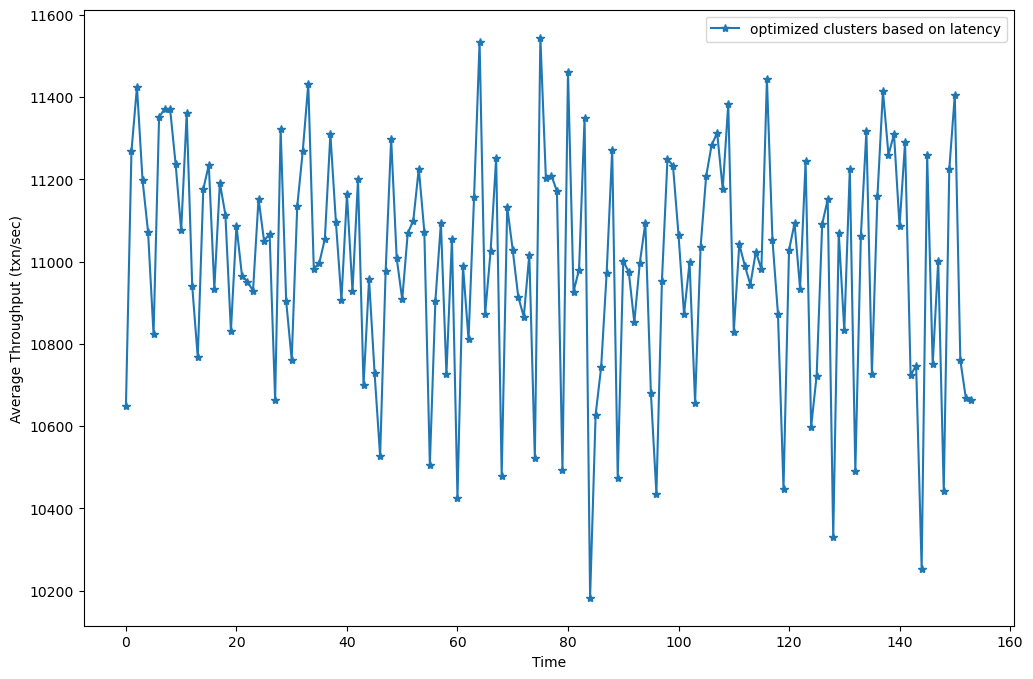

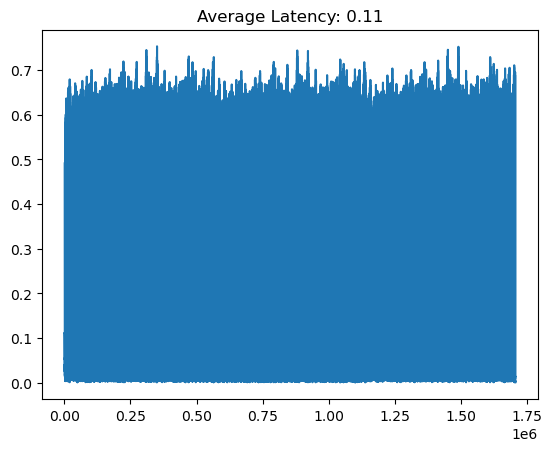

In [ ]:
for cfig in config_list:   
    try:

        os.system('rm node_info.csv')
        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        lines  = []



        for node_id in node_info_dict['node_id'].keys():
        #     print(node_id, node_info_dict['node_id'][node_id], node_info_dict['region'][node_id])

            lim = node_info_dict['node_id'][node_id]
            reg = node_info_dict['region'][node_id].strip().replace('\'', '')

        #     print(reg)

            cmd = 'gcloud compute instances create resdb-'+f"{lim:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
        #     cmd = 'gcloud compute instances create resdb-'+f"{lim:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-small --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

            lines.append(cmd)


        lines


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)


        instance_type = 'e2-small'


        redirect = '>'
        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')





        !cat all_internal_ips
        ! echo " " 
        # !cat all_external_ips



        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data1, data2

        data2, len(data2)

        data = []

        # for i in range(len(data1)):
        #     if data1[i]!='None':
        # #         data.append(data1[i] + '    ' + data2[i])
        #         data.append('127.0.0.1'+ '    ' + '127.0.0.1')


        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])
        #         data.append('127.0.0.1'+ '    ' + '127.0.0.1')

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict

        for item in node_info_dict['publicAndprivateIP']:
            print(node_info_dict['publicAndprivateIP'][item])

        with open('replicas.txt', 'w') as f:

            for item in node_info_dict['publicAndprivateIP']:

                if (node_info_dict['ServerOrClientregion'][item] ==0):
                    f.write("%s\n" % node_info_dict['publicAndprivateIP'][item])


        node_info_dict['ServerOrClientregion']

        ! cat replicas.txt

        with open('clients.txt', 'w') as f:

            for item in node_info_dict['publicIP']:

                if (node_info_dict['ServerOrClientregion'][item] ==1):
                    f.write("%s\n" % node_info_dict['publicIP'][item])

        os.system('cat clients.txt')

        node_info_dict

        # def run_server_node_remote(i):
        #     ip = lines[i]
        # #     if ip!='None' and( ip in nodeIps[:-3]):
        #     if ip!='None' and( ip in nodeIps):


        #         current = (ip.split('.'))
        #         command = './examples/hotstuff-app --conf hotstuff.gen-sec'+str(nodeIps.index(ip))+'.conf '

        #         print(i,command)



        # for i in range(len(lines)):
        #     print(i)
        #     run_server_node_remote(i)




        # def run_client_node_remote(i):
        #     ip = lines[i]
        #     if ip!='None' and( ip in clientIps):

        #         current = (ip.split('.'))
        #         command = './examples/hotstuff-client --idx 0 --iter -1 --max-async 5 >../nohup.out 2>&1 &"'

        #         print(command)

        # for i in range(len(lines)):
        #     print(i)
        #     run_client_node_remote(i)


        # # # os.system('echo 3108 | sudo -S ls')/FinalKeys.pem

        # # experiment = 'exp_f1'

        # # os.system('echo 3108 | sudo -S sh job_mini1.sh '+experiment)

        # # os.system('./run_cli.sh new '+experiment+'_cli;')
        # # os.system('sleep 30;')
        # # kill_nodes(3)

        # # # run_server_node(3)

        # # os.system('sleep 30;')

        # # os.system('./run_cli.sh stop '+experiment+'_cli;')
        # # os.system('./run.sh stop '+experiment+';')
        # # os.system('./run_cli.sh fetch '+experiment+'_cli;')
        # # os.system('cat '+experiment+'_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')



        # def run_server_node(i):
        #     ip = lines[i]
        # #     if ip!='None' and( ip in nodeIps[:-3]):
        #     if ip!='None':

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd /home/ubuntu/testbed/'+experiment+'/0/conf/; sudo nohup ../../../../libhotstuff/examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'+experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)


        # def run_node(i):
        #     ip = lines[i]
        # #     if ip!='None' and( ip in nodeIps[:-3]):
        #     if ip!='None' and ip in lines[:nnodes]:

        #         current = (ip.split('.'))
        #         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf > ../temp/nohup_'+str(i)+'.out 2>&1 &'

        #         print(command)
        #         os.system(command)


        # def run_client(i):
        #     ip = lines[i]
        #     client_no = i - nnodes
        #     if ip!='None' and( ip in lines[nnodes:]):

        #         current = (ip.split('.'))
        #         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'.out 2>&1 &'

        #         print(command)
        #         os.system(command)



        # def run_client2(i):
        #     ip = lines[i]
        #     client_no = i - nnodes
        #     if ip!='None' and( ip in lines[nnodes:]):

        #         current = (ip.split('.'))
        #         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'_2.out 2>&1 &'

        #         print(command)
        #         os.system(command)



        # # def run_join_node(i):
        # #     ip = lines[i]
        # #     if ip!='None':

        # #         current = (ip.split('.'))
        # #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        # #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'
        # #         +experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        # #         print(command)
        # #         os.system(command)




        # # def kill_nodes(i):
        # #     ip = lines[i]

        # #     if ip!='None':
        # #         current = (ip.split('.'))
        # #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        # #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'

        # #         output = subprocess.getoutput(command)
        # #         print(output)





        # # # run_server_node(3)

        # # # current



        # # os.system('cat exp_4c5n_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')


        def setup_remote(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'

                print(command)

                output = os.system(command)
                print(output)


        def setup_remote2(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))



                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; git pull;"'

                print(command)

                output = os.system(command)
                print(output)


        def git_pull_remote(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo git pull;"'


                output = subprocess.getoutput(command)
                print(output)



        # def run_join_node_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-1]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)



        # def run_join_node1_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-1]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)

        # def run_join_node2_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-2]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)

        # def run_join_node3_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-3]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)




        def kill_nodes_remote(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))

                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                output = subprocess.getoutput(command)
                print(output)



        def clean_nodes_remote(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))

                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm -f nohup.out;"'


                print(command)
                os.system(command)








        experiment = 'test'
        os.system('rm hotstuff.gen*')
        os.system('echo 3108 | sudo -S sh job_mini.sh '+ experiment)

        os.system('cp hotstuff.gen* ../../')

        import os
        os.system('cd ../../; git add .; git commit -m "Testing"; git push -f')


        # # def setup_remote3(i):

        # #     ip = node_info_dict['publicIP'][i] 
        # #     if ip!='None':
        # #         current = (ip.split('.'))
        # #         command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        # #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
        # #         print(command)

        # #         output = os.system(command)
        # #         print(output)


        # results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
        #                                                                        for i in [9])#node_info_dict['node_id'])


        # print(results)  

        time.sleep(60)


        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
                                                                               for i in node_info_dict['node_id'])


        print(results)  



        # for i in node_info_dict['publicIP']:
        #     print(i)
        #     setup_remote2(i)

        # compile_remote(0)



        def compile_remote(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))


                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


                print(command)
                output = os.system(command)
                print(output)






        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                               for i in list(node_info_dict['node_id'].keys()))


        print(results)  

        time.sleep(200)

        # def compile_remote(i):

        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None':
        #         current = (ip.split('.'))
        #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


        # #         output = os.system(command)
        #         print(command)


        # for i in range(60):
        #     compile_remote(i)

        # time.sleep(420)




        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                               for i in node_info_dict['node_id'])


        print(results)  


        # node_info_dict

        def run_server_node_remote(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps[:-3]):

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))


                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'

                print(i,command)
                os.system(command)


        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_server_node_remote)(i)\
                                                                               for i in node_info_dict['node_id'])

        print(results)  
        time.sleep(45)


        # for i in node_info_dict['publicIP']:
        #     kill_nodes_remote(i)

        # def run_client_node_remote_print(i):
        #     ip = node_info_dict['publicIP'][i] 

        #     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 5 >../nohup.out 2>&1 &"'

        #         print(command)

        # for i in node_info_dict['publicIP']:
        #     run_client_node_remote_print(i)

        # def run_server_node_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        # #     if ip!='None' and( ip in nodeIps[:-3]):

        #     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'

        #         print(i,command)
        # #         os.system(command)

        # f



        def run_client_node_remote(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 400 >../nohup.out 2>&1 &"'


                print(command)
                os.system(command)




        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                               for i in node_info_dict['node_id'])

        print(results)  


        # for i in node_info_dict['publicIP']:
        #     run_client_node_remote(i)

        time.sleep(150)

        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(kill_nodes_remote)(i)\
                                                                               for i in node_info_dict['publicIP'])


        os.system('cd ../../../dump_files; echo 3108 | sudo -S  rm *')

        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../../../dump_files/nohup_server_'+str(node_info_dict['ServerID'][i])+'.out'
                print(command)
                os.system(command)
                break

        # result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


        # result = result.decode("utf-8") 

        # lines = result.split('\n')

        # #     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
        # commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

        # Times = []
        # lats = []

        # for line in lines:
        #     m = commit_pat.match(line)
        #     if m:
        # #             try:

        #             time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
        #             float((line.split(' ')[1]).split(':')[2])
        #             Times.append(time_item)        

        #             lats.append(float(m.group(2)))
        #             print(lats[-1])
        # #             except:

        # lines


        # def getThroughput(experiment):

        #     result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


        #     result = result.decode("utf-8") 

        #     lines = result.split('\n')

        #     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
        # #     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

        #     Times = []
        #     lats = []

        #     for line in lines:
        #         m = commit_pat.match(line)
        #         if m:
        #             try:

        #                 time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
        #                 float((line.split(' ')[1]).split(':')[2])
        #                 Times.append(time_item)        

        #                 lats.append(float(m.group(2)))
        # #                 print(lats[-1])
        #             except:
        #                 continue


        #     begin_time = None
        #     values = []
        #     interval = 1
        #     cnt = 0
        #     Times.sort()
        #     for timestamp in Times:
        #         if begin_time is None:
        #             begin_time = timestamp
        #             next_begin_time = timestamp +interval

        #         while timestamp >= next_begin_time:
        #             begin_time = next_begin_time
        #             next_begin_time += interval
        #             values.append(cnt)
        #             cnt = 0
        #         cnt += 1
        #     values.append(cnt)

        # #     lats, _ = remove_outliers(lats)
        # #     print(len(values))


        #     return np.arange(len(values))*interval,np.array(values)/interval, lats

        experiment = '../../dump_files'
        X,Y, lats = getThroughput(experiment)


        print(np.sum(Y)/len(Y), np.average(lats))

        lats

        lats

        np.sum(Y)

        s1, s2 = X[:-2],Y[:-2]

        np.average(s2[10:40]),np.average(lats[-33:-3])

        lats


        experiment = cfig

        if not os.path.exists('../../../Experiments/ho_'+experiment):
            os.mkdir('../../../Experiments/ho_'+experiment)

        os.system('cp -r ../../../dump_files ../../../Experiments/ho_'+experiment)    


        fig = pl.figure(figsize = (12, 8))
        fig.patch.set_facecolor('white')
        pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Average Throughput (txn/sec)')
        # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

        # pl.ylim(0,10000)
        pl.savefig('../../../Experiments/ho_'+experiment+ '/thput.png', dpi =150, bbox_inches = 0 )
        pl.show()
        pl.clf()

        pl.plot(lats)
        pl.title('Average Latency: '+str( np.round(np.average(lats),2) ))
    #     pl.ylim(0,1)
        pl.savefig('../../../Experiments/ho_'+experiment+ '/lats.png', dpi =150, bbox_inches = 0 )
        pl.show()
        pl.clf()





        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')   

    except:
        
        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
        continue


# lats

# os.system('grep -n -r "LatencyPlot: new node sending join request message" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Received first message with new node info" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Leader received with tentative sets from all peer nodes" ../../../dump_files/')        

# 1000*(32.776365 - 32.768622)

# os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

# os.system('grep -n -r "LatencyPlot: Received initial join message" ../../../dump_files/')        

# os.system('grep -n -r "Sending Join Init message with height" ../../../dump_files/')        

# 1000*(17.534818-17.534437)

# os.system('grep -n -r "LatencyPlot: Sent response to  initial join message" ../../../dump_files/')        


    
# os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

# 17.536482

In [ ]:
# os.system('cp -r ../../../dump_files ../../../Experiments/ho_'+experiment)    


In [ ]:
#         pl.plot(lats)


In [ ]:
# os.system('grep -n -r "LatencyPlot: Received 1st MC message" ../../../dump_files/')

In [ ]:
# os.system('grep -n -r "LatencyPlot: before sending first mc message" ../../../dump_files/')

In [ ]:
# 1000*(32.676090-32.612236)

In [ ]:
# os.system('grep -n -r "LatencyPlot: going to execute based on 2nd MC message" ../../../dump_files/')


# os.system('grep -n -r "LatencyPlot: Finished execution" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Processing message from client" ../../../dump_files/')    

In [ ]:
# os.system('grep -n -r "LatencyPlot: before initial join message" ../../../dump_files/')    

In [ ]:
# # os.system('grep -n -r "LatencyPlot: " ../../../dump_files/')

# 1000*(11.479877-11.479442), 1000*(11.484887-11.479877),1000*(56.048590-56.046569), 1000*(56.050021 - 56.048590)

# # exec, # first mc, #second mc

# 1000*(56.050377 - 56.050181), 1000*(56.049389-56.049025), 1000*(56.050875-56.049389), 1000*(56.046557-56.038591) 


# # with open('opt1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('opt1.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)
  
    








# # with open('equiCluster1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('equiCluster1.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)
  
    
    
    
# # with open('equiCluster.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)

    
# # with open('lat.npy', 'rb') as f:
# #     lat1 = np.load(f)
# #     lat2 = np.load(f)

    
    
# # with open('opt.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)


# fig = pl.figure(figsize = (12, 8))
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')

# # pl.plot(eq1,eq2, '-*', label = 'optimized clusters: equal clusters (7 (R1),7 (R2)')
# # pl.plot(lat1,lat2, '-*', label = 'optimized clusters: latency (9 (R1),5 (R2))')
# # pl.plot(opt1,opt2, '-*', label = 'optimized clusters: latency and heterogeneity (4 (R1),5 (R1), 5 (R2))')
# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Average Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,350)
# # pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

## Single Non-Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Single Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/NodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave

## Multiple Non Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==7:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==11:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.axvline(x=60, ls='--', color = 'green')
pl.axvline(x=80, ls='--', color = 'blue')

pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Multiple Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/MultiNodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave